<a href="https://colab.research.google.com/github/Gustavo2022Palomeque/Desaf-o/blob/main/Telecom_Desaf%C3%ADo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vista previa de los datos aplanados y limpios:
   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes          

<ipython-input-1-21d49b1e4c0c>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Churn', palette='viridis')


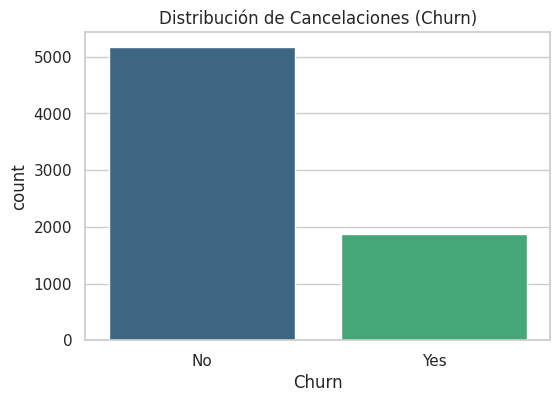

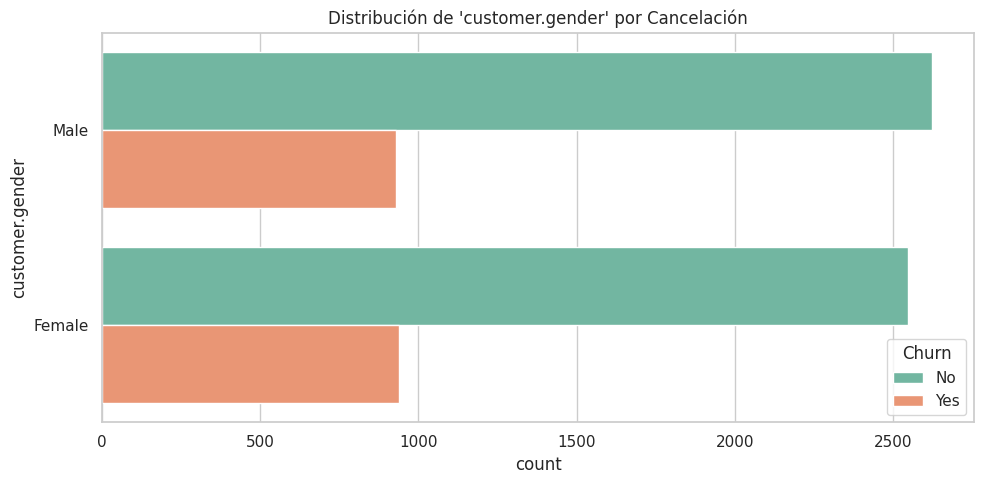

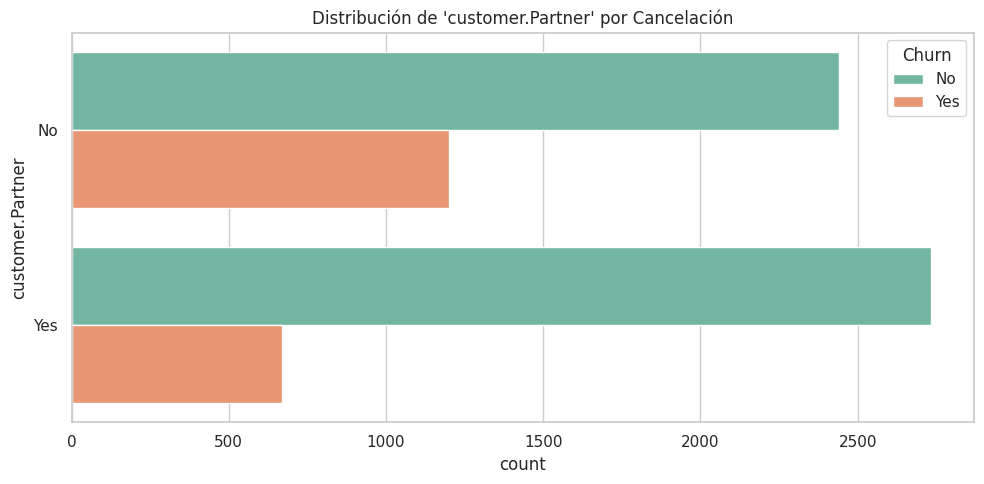

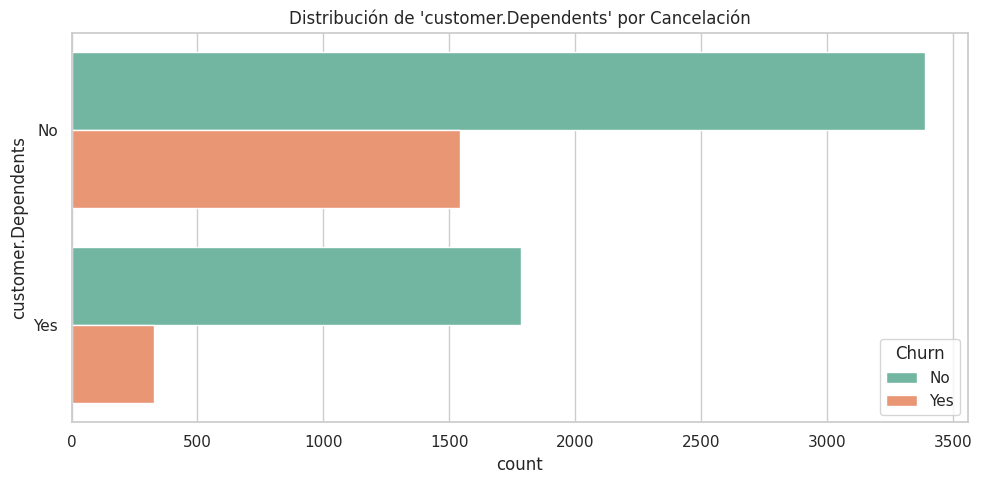

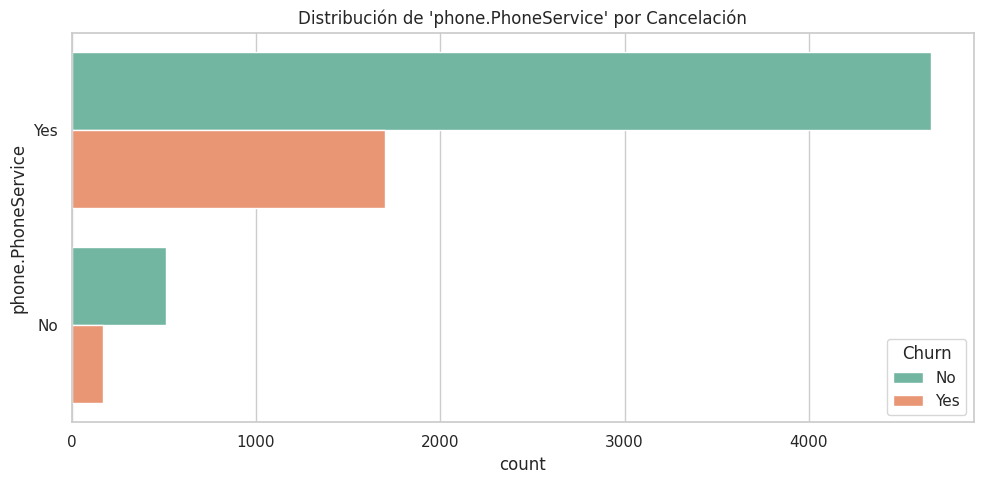

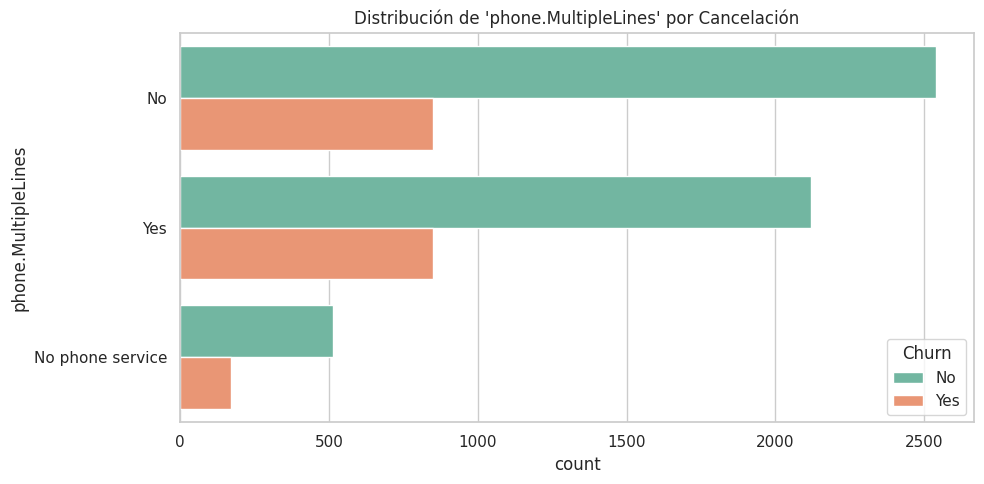

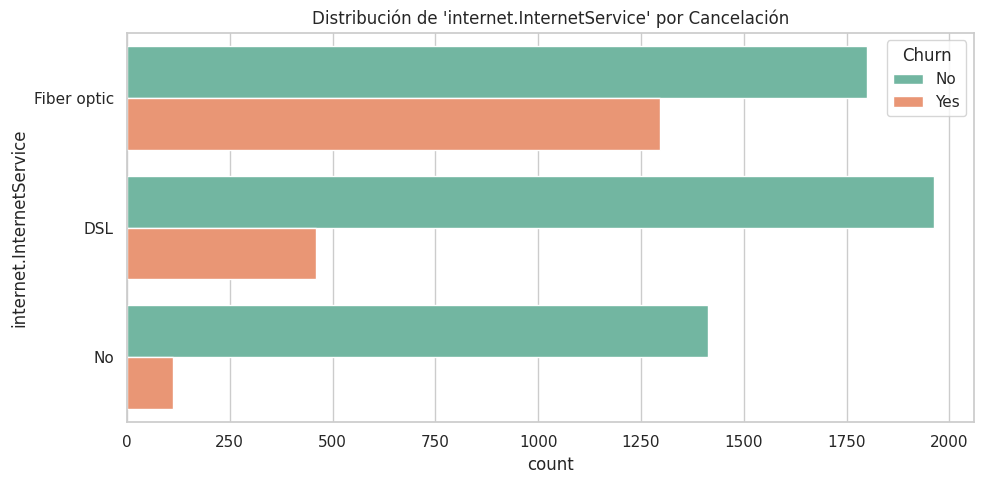

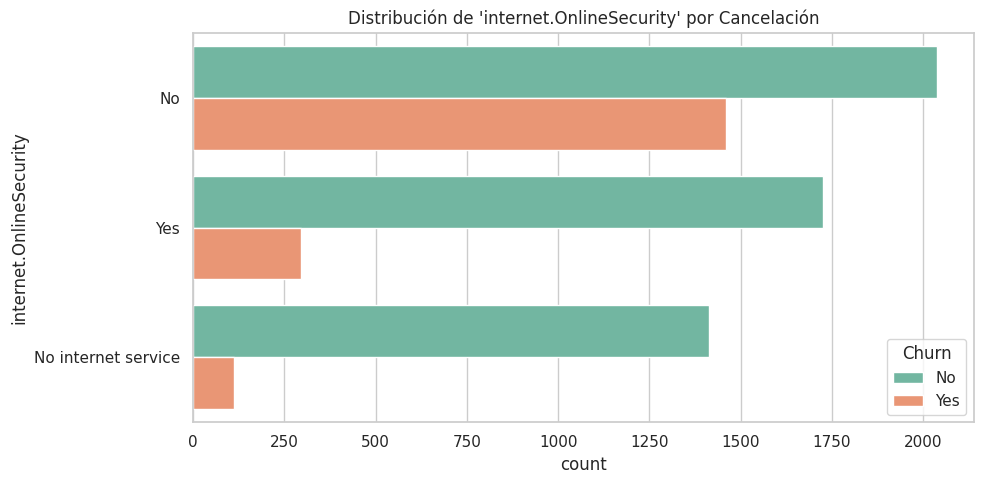

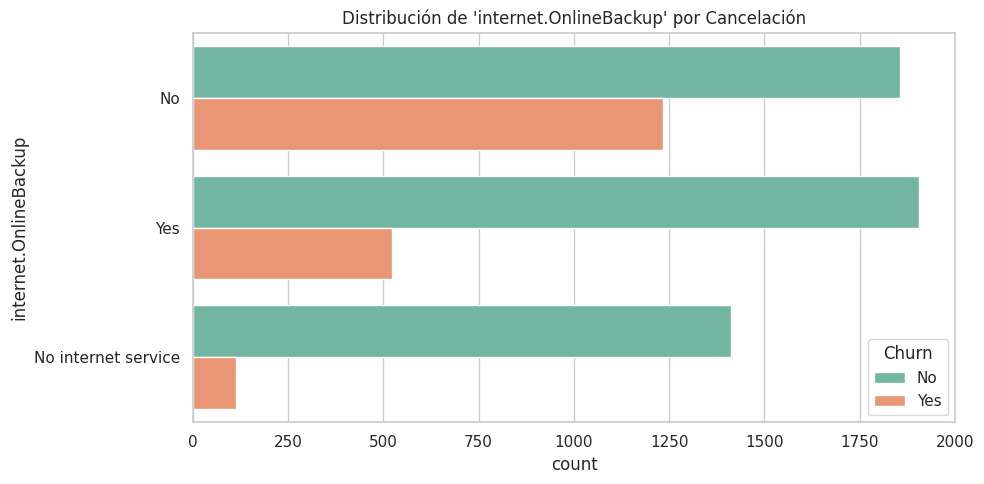

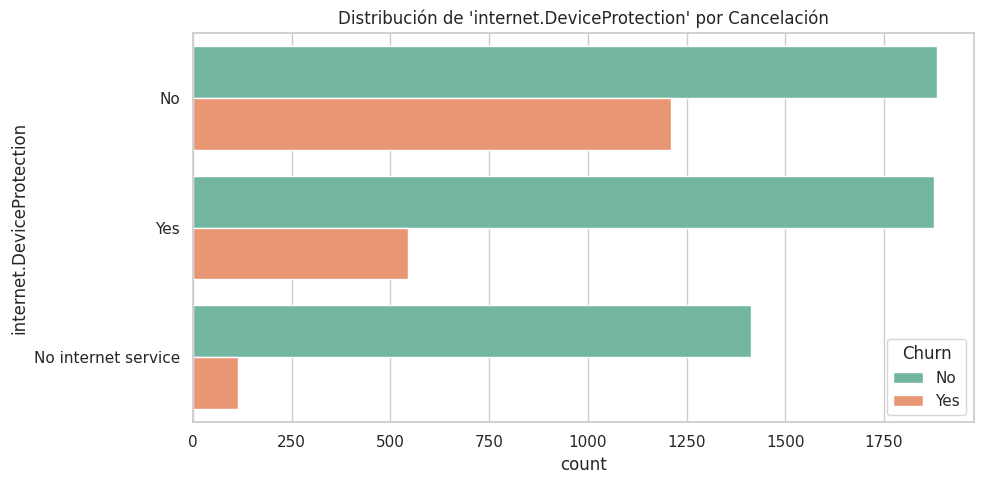

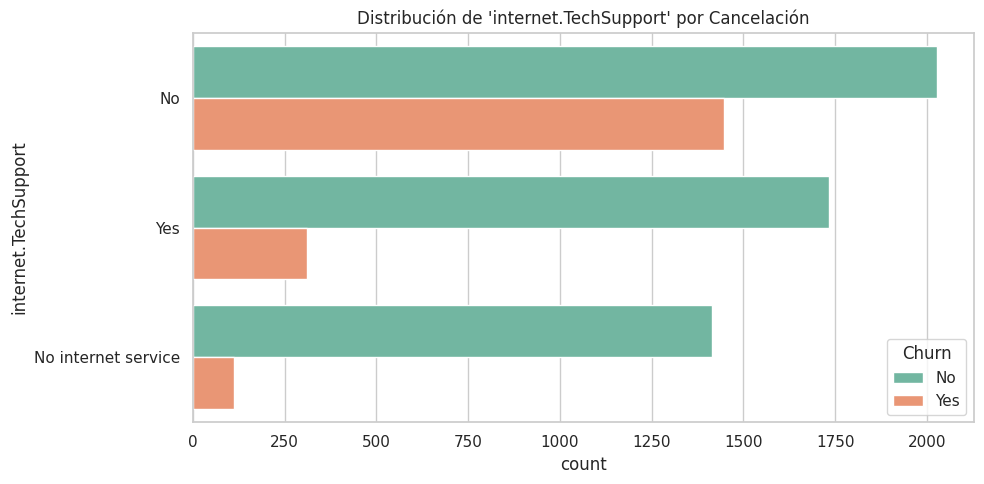

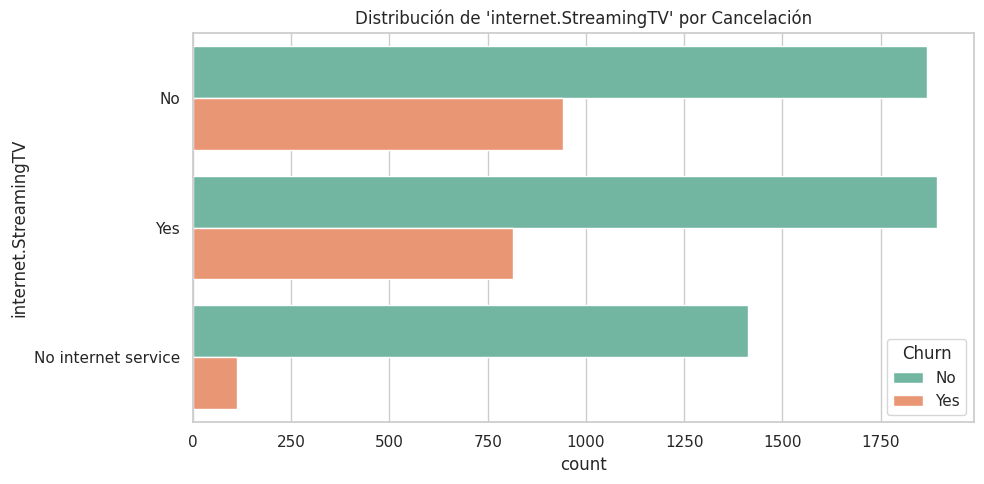

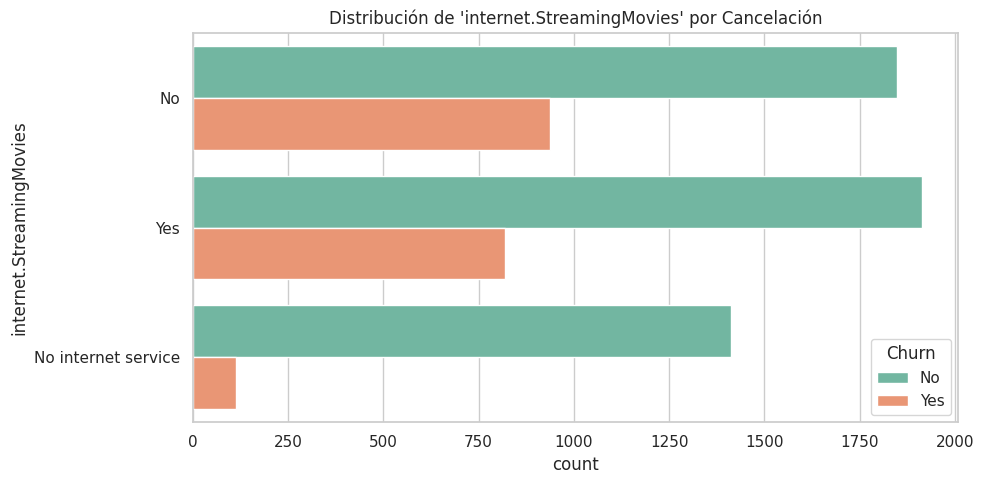

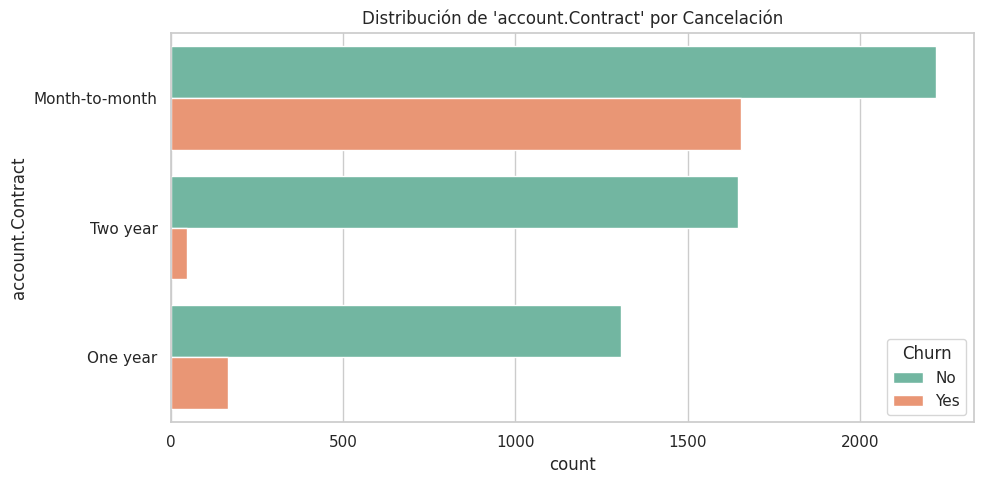

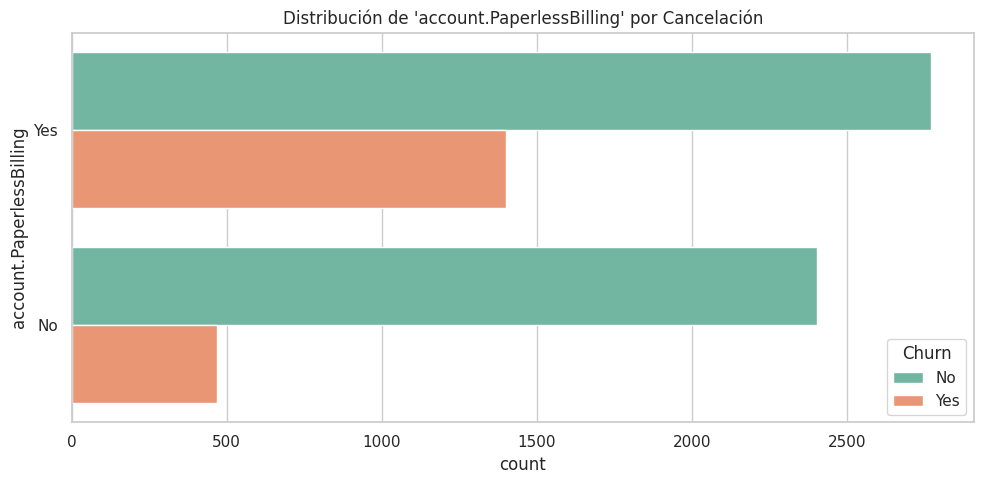

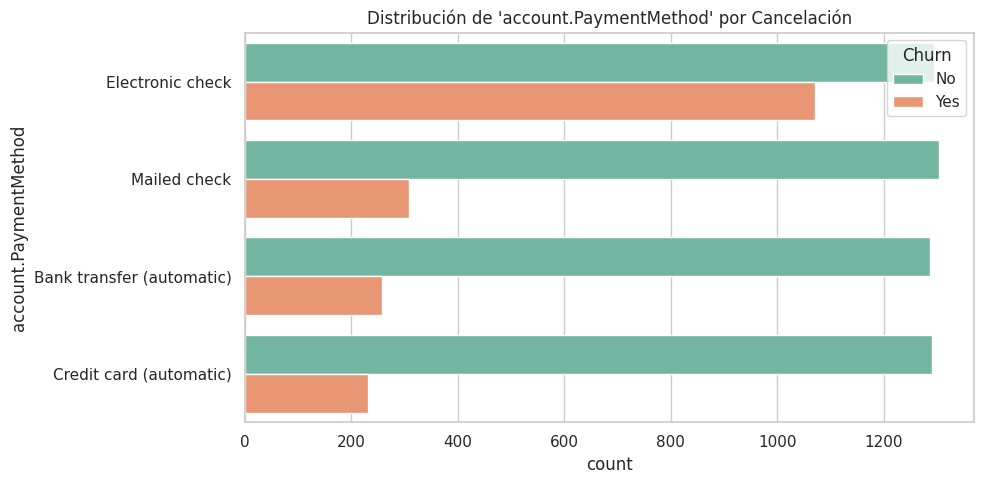

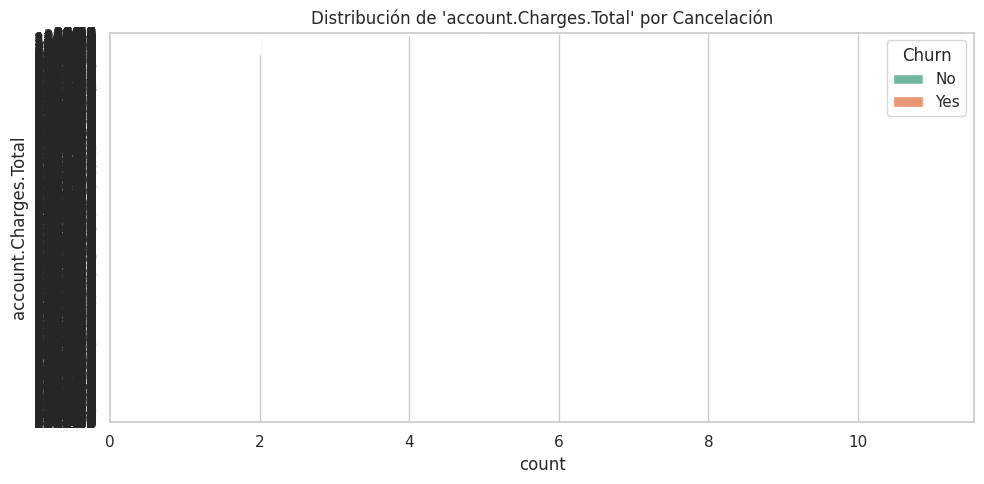

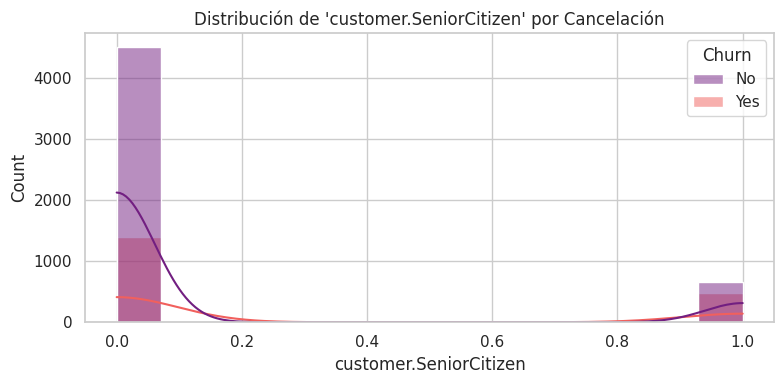

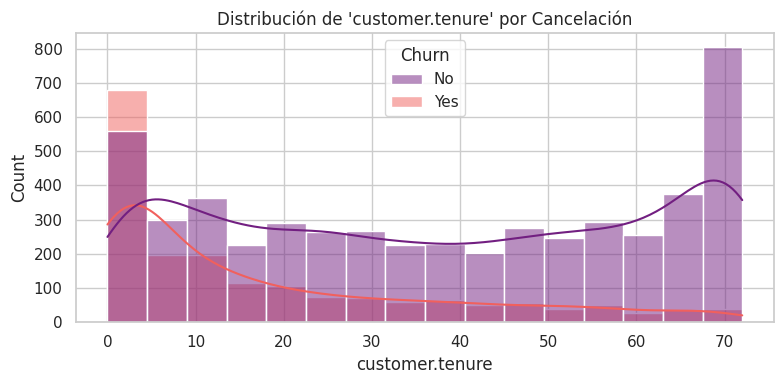

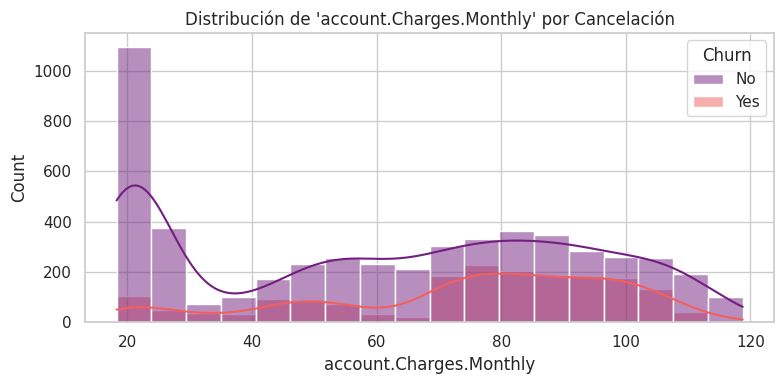

Se han truncado las últimas 5000 líneas del flujo de salida.
3                         False                        False   
4                         False                        False   

   account.Charges.Total_632.95  account.Charges.Total_6322.1  \
0                         False                         False   
1                         False                         False   
2                         False                         False   
3                         False                         False   
4                         False                         False   

   account.Charges.Total_6325.25  account.Charges.Total_6328.7  \
0                          False                         False   
1                          False                         False   
2                          False                         False   
3                          False                         False   
4                          False                         False   

   account.Charges.Tot

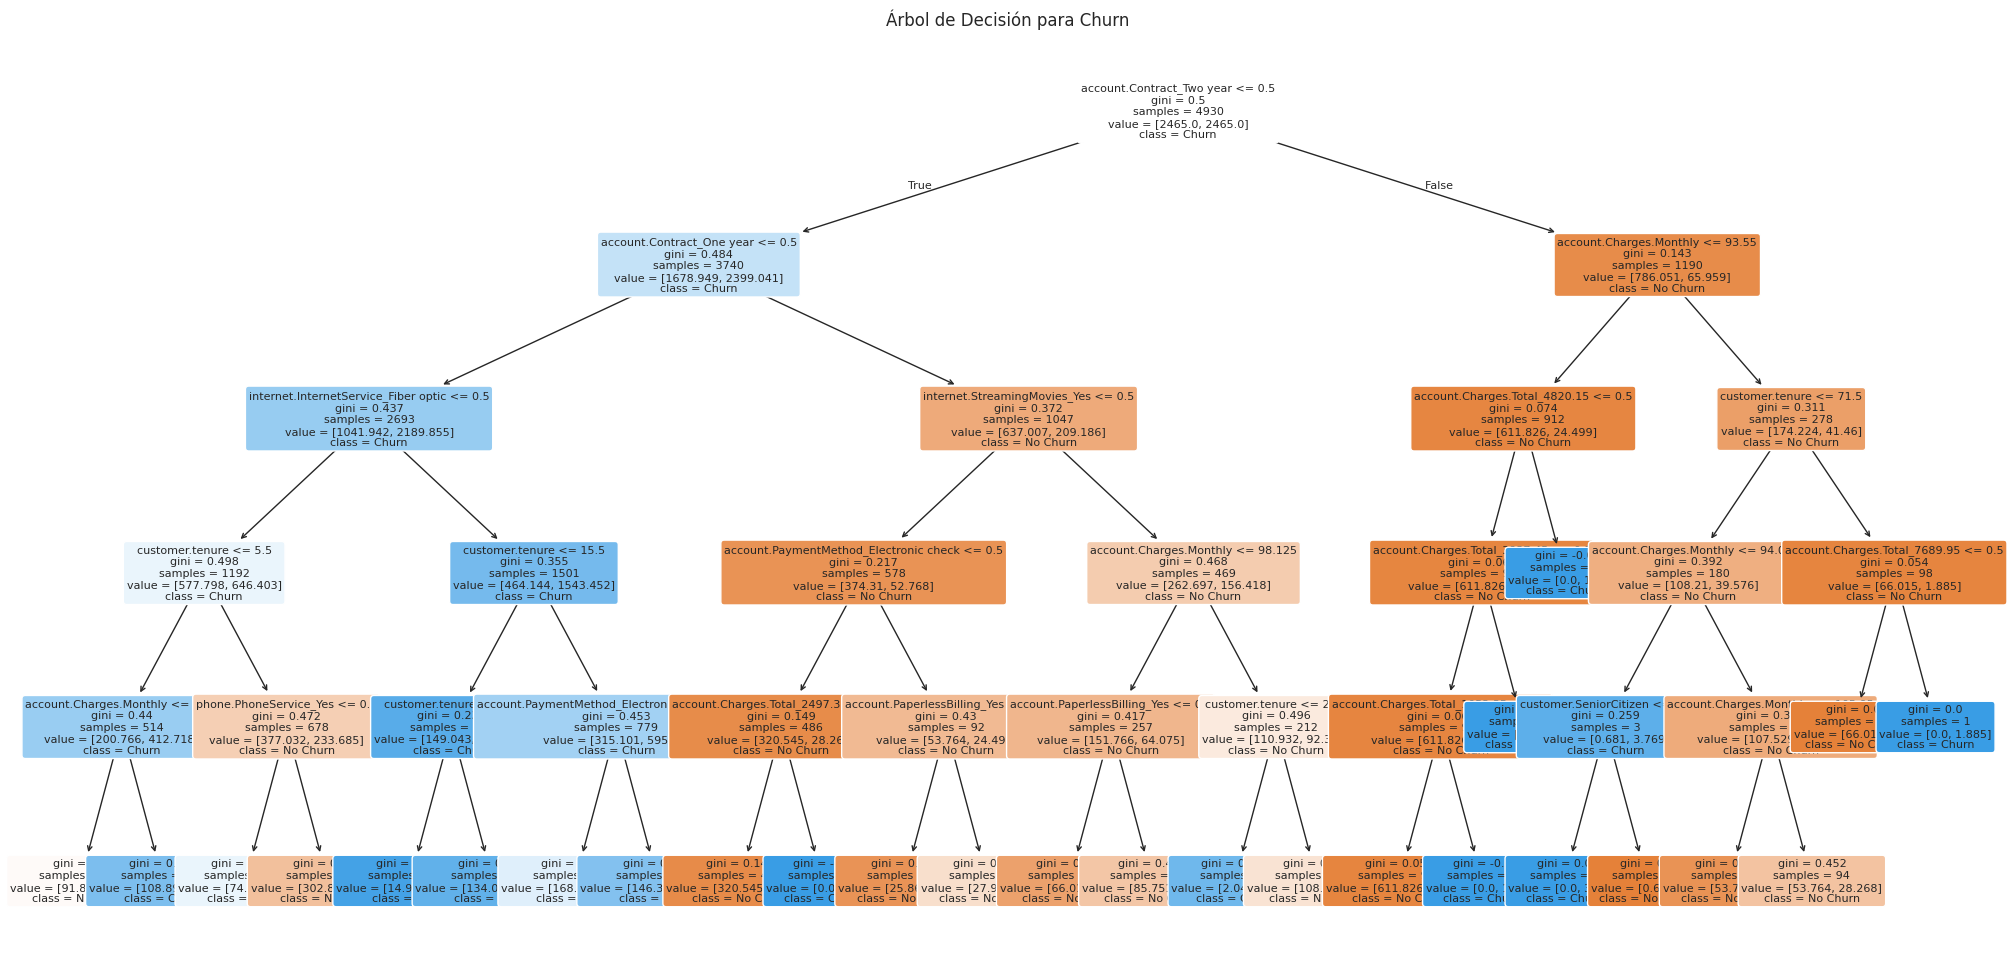

In [1]:
# %% Importaciones
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import tree

# %% Configuración General
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None) # Ver todas las columnas en los outputs

# %% 1. Carga y Limpieza de Datos
# Cargar el dataset original
raw_data = pd.read_json("/content/TelecomX_Data.json")

# MEJORA: Aplanar las columnas anidadas usando json_normalize
# Esto convierte columnas como 'customer' en 'customer.gender', 'customer.SeniorCitizen', etc.
nested_cols = ['customer', 'phone', 'internet', 'account']
flat_data_list = []

for col in nested_cols:
    normalized_col = pd.json_normalize(raw_data[col]).add_prefix(f'{col}.')
    flat_data_list.append(normalized_col)

# Combinar los datos aplanados con las columnas no anidadas
data = pd.concat([raw_data.drop(columns=nested_cols), *flat_data_list], axis=1)

# MEJORA: Limpieza más robusta de la columna 'Churn'
# Eliminar espacios en blanco y luego reemplazar cadenas vacías si las hubiera
data['Churn'] = data['Churn'].str.strip()
data = data[data['Churn'] != ''] # Mantener solo filas con 'Yes' o 'No'
data = data.dropna(subset=['Churn']) # Asegurar que no haya NAs

print("Vista previa de los datos aplanados y limpios:")
print(data.head())
print("\nTipos de datos de las columnas nuevas:")
data.info()


# %% 2. Análisis Exploratorio de Datos (EDA)
print("\nDistribución de 'Churn':")
print(data['Churn'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Churn', palette='viridis')
plt.title('Distribución de Cancelaciones (Churn)')
plt.show()

# Identificar columnas categóricas y numéricas para visualizar
# Excluimos IDs, y la variable objetivo
categorical_features = data.select_dtypes(include=['object', 'category']).drop(columns=['customerID', 'Churn']).columns
numerical_features = data.select_dtypes(include=['number']).columns

# MEJORA: Visualizar las variables categóricas ANTES de codificarlas
for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data, y=col, hue='Churn', palette='Set2', order=data[col].value_counts().index)
    plt.title(f"Distribución de '{col}' por Cancelación")
    plt.tight_layout()
    plt.show()

# Visualizar las variables numéricas
for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=data, x=col, hue='Churn', kde=True, palette='magma')
    plt.title(f"Distribución de '{col}' por Cancelación")
    plt.tight_layout()
    plt.show()


# %% 3. Preparación de Datos para el Modelo
# Eliminar columna de ID que no aporta al modelo
data_model = data.drop(columns=['customerID'])

# MEJORA: Usar One-Hot Encoding para variables categóricas
data_model = pd.get_dummies(data_model, columns=categorical_features, drop_first=True)

# La columna 'Churn' (Yes/No) se convierte automáticamente en 'Churn_Yes' (1/0)
# si está incluida en get_dummies, o la podemos convertir manualmente.
if 'Churn_Yes' in data_model.columns:
    data_model = data_model.rename(columns={'Churn_Yes': 'Churn'})
else:
    # Si 'Churn' no fue codificada (por ej, si no era 'object'), la convertimos manualmente
    data_model['Churn'] = data_model['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Asegurar que todas las columnas sean numéricas (después de get_dummies, esto es seguro)
for col in data_model.columns:
    data_model[col] = pd.to_numeric(data_model[col], errors='coerce')
data_model = data_model.fillna(0) # Rellenar posibles NaNs residuales

print("\nVista previa de los datos listos para el modelo:")
print(data_model.head())


# %% 4. División y Entrenamiento del Modelo
# Separar variables predictoras (X) y objetivo (y)
X = data_model.drop(columns=['Churn'])
y = data_model['Churn']

# MEJORA: Usar 'stratify' para mantener la proporción de Churn en los sets de train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\nForma de los conjuntos de datos:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Entrenamiento del Árbol de Decisión
clf = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight='balanced') # max_depth previene overfitting
clf.fit(X_train, y_train)


# %% 5. Evaluación del Modelo
y_pred = clf.predict(X_test)

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

print(f"\nPrecisión (Accuracy) del modelo: {accuracy_score(y_test, y_pred):.2f}")


# %% 6. Visualización del Árbol de Decisión
plt.figure(figsize=(25,12))
tree.plot_tree(clf,
               feature_names=X.columns,
               class_names=['No Churn', 'Churn'],
               filled=True,
               rounded=True,
               fontsize=8)
plt.title("Árbol de Decisión para Churn")
plt.show()
